# Librerias

In [7]:

import pandas as pd
import os
import pmdarima
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.stattools import adfuller,kpss
from arch.unitroot import PhillipsPerron as PP,DFGLS

# Modelizacion
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Cargamos los datos
datos = pd.read_excel("Inflation.xlsx")
datos=datos.dropna()

In [14]:
# Eliminamos la variable que no nos interesa
del (datos["Monthly_Rate"])
datos.columns
# Pasamos la fecha a formato fecha
datos["observation_date"] = pd.to_datetime(datos["observation_date"], format="%Y-%m-%d %H:%M:%S")

# Pasamos la fecha al indice
datos.index = datos["observation_date"]
del (datos["observation_date"])


In [15]:
datos.head()

,Monthly_CPI,Monthly_Inflation,Bank Rate
observation_date,,,
1960-02-01,1.678984,1.000000,4.0
1960-03-01,1.664416,0.991323,4.0
1960-04-01,1.678984,1.008753,4.0
1960-05-01,1.689910,1.006508,4.0
1960-06-01,1.704479,1.008621,4.0


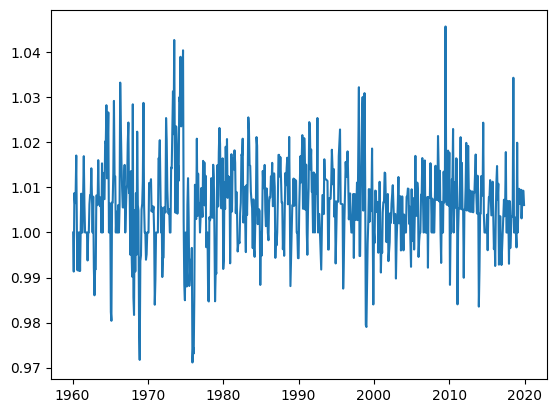

In [16]:
plt.plot(datos["Monthly_Inflation"])

## Procedemos a calcular el numero de diferencias


In [17]:
# Respecto a la observacion anterior
pmdarima.arima.ndiffs(datos["Monthly_Inflation"])

0

In [19]:
# Estacionalmente con estacionalidad anual.
pmdarima.arima.nsdiffs(datos["Monthly_Inflation"], m = 12)

0

In [124]:
pmdarima.arima.ndiffs(datosdiff_Est)

1

In [125]:
pmdarima.arima.nsdiffs(datosdiff_Est, m = 12)

0

## Trasformamos a log

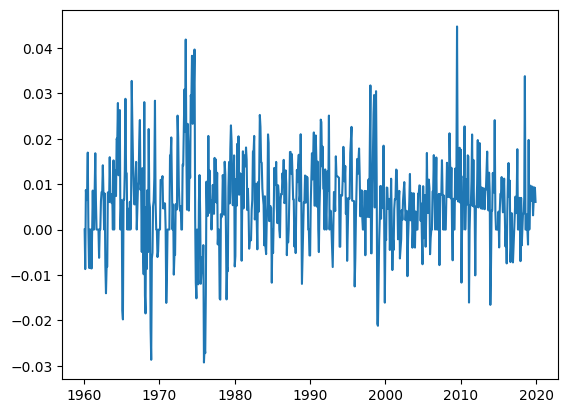

In [23]:
datos["Monthly_Inflation"] = datos["Monthly_Inflation"].astype(float)
Log_Datos = pd.DataFrame(np.log(datos["Monthly_Inflation"]))

# Graficamos.
plt.plot(Log_Datos["Monthly_Inflation"])

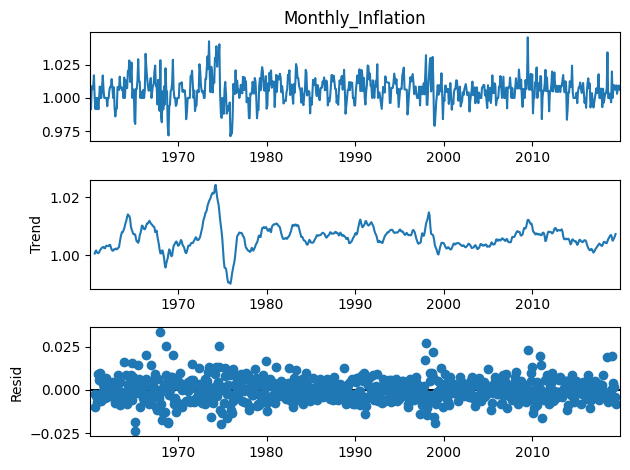

In [26]:
SerieDescompuesta = seasonal_decompose(datos["Monthly_Inflation"], model='additive')
SerieDescompuesta.plot(observed=True, seasonal=False, trend=True, resid=True, weights=False);

## Suavizado


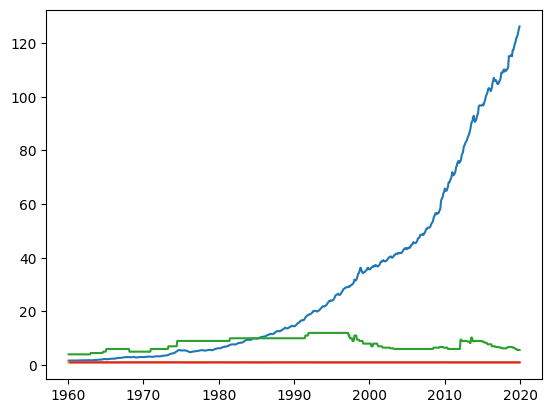

In [ ]:
# Suavizado basado en medias moviles
datos['mov_avg'] = datos["Monthly_Inflation"].rolling(4).mean()
# Graficamos esta nueva serie
plt.plot(datos)
del (datos['mov_avg'])

# Estariedad de la serie

## Estariedad de la serie sin diferencias

### ADF
H0: No estacionario (raiz unitaria)

In [31]:
ADF = adfuller(datos["Monthly_Inflation"])

# Mostramos los resultados
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -7.241416
p-value: 0.000000


No tenemos suficiente evidencia estadistica para rechazar H0 -> Serie no estacionaria

### KPSS
H0: Serie Estacionaria


In [32]:
KPSS = kpss(datos["Monthly_Inflation"])

# Mostramos los valores
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])

KPSS Statistic: 0.074279
p-value: 0.100000


/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Rechazamos H0 -> Serie No estacionaria


### PP
H0: Serie  NO Estacionaria


In [33]:
pp_results = PP(datos["Monthly_Inflation"])

# Mostramos los valores
pp_results

Test Statistic,-16.195
P-value,0.000
Lags,20


No tenemos suficiente evidencia estadistica para rechazar H0 -> Serie no estacionaria


### ERS

H0: Serie  NO Estacionaria

In [34]:

ERS = DFGLS(datos["Monthly_Inflation"])

# Mostramos los valores
ERS

Test Statistic,-3.693
P-value,0.000
Lags,18


No tenemos suficiente evidencia estadistica para rechazar H0 -> Serie no estacionaria

No rechazamos H0

Pero parece que tiene mejor pinta que los pasados

# Modelización

## Correlograma


Estamos viendo las relaciones entre las observaciones $ y_t  \to  y_{t-1}, y_{t-2}, \dots $ 
Si existe alguna relación periodica o no en los correlogramas. Pero cuidado porque a veces las relaciones que se ven no tienen sentido de negocio. Por ejemplo en el parcial se esta viendo una relacion cada 6 meses pero no tiene sentido de negocio,

Para le modelo queremos predecir los datos, por eso metemos el log sin la diff

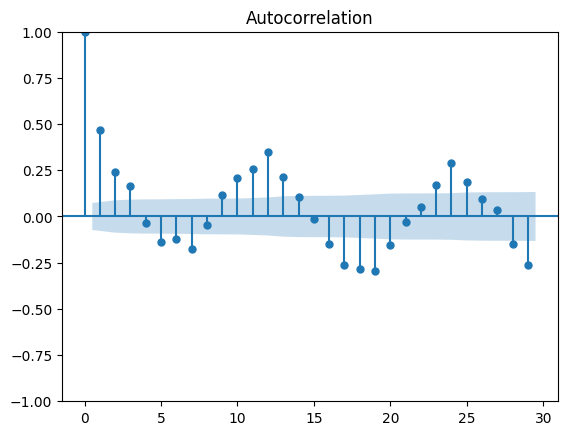

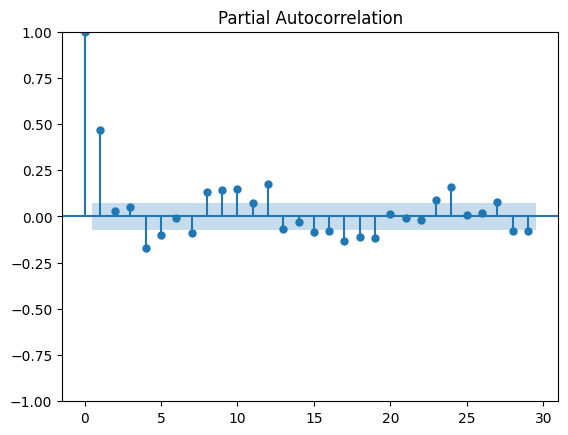

In [36]:
plot_acf(datos["Monthly_Inflation"]);
plot_pacf(datos["Monthly_Inflation"]);

## Dividimos los datos en train y test
Para le modelo queremos predecir los datos, por eso metemos el log sin la diff

In [45]:
datos.loc[:"2014-12-01 00:00:00"]["Monthly_Inflation"]

observation_date
1960-02-01    1.000000
1960-03-01    0.991323
1960-04-01    1.008753
1960-05-01    1.006508
1960-06-01    1.008621
                ...   
2014-08-01    1.003968
2014-09-01    1.000000
2014-10-01    1.000000
2014-11-01    1.000000
2014-12-01    1.000000
Name: Monthly_Inflation, Length: 659, dtype: float64

In [58]:
train = datos.loc[:"2014-12-01 00:00:00"]
test = datos["2015-01-01 00:00:00":]
print(f"Nº datos de entrenamiento: {train.size}, nº datos de test: {test.size} ")

Nº datos de entrenamiento: 1977, nº datos de test: 180 


## Entrenamos 

In [59]:
train.iloc[:,1]

observation_date
1960-02-01    1.000000
1960-03-01    0.991323
1960-04-01    1.008753
1960-05-01    1.006508
1960-06-01    1.008621
                ...   
2014-08-01    1.003968
2014-09-01    1.000000
2014-10-01    1.000000
2014-11-01    1.000000
2014-12-01    1.000000
Name: Monthly_Inflation, Length: 659, dtype: float64

In [61]:
model = sm.tsa.statespace.SARIMAX(train.iloc[:,1], order=(1,0,2), seasonal_order=(1,0,2,12))

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [62]:
ArimaModel = model.fit()
ArimaModel.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30304D+00    |proj g|=  2.71320D+01
  ys=-9.973E-19  -gs= 5.496E-16 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -3.32293D+00    |proj g|=  4.73299D+00
  ys=-3.430E-09  -gs= 3.200E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-2.400E-06  -gs= 1.484E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     10    145      4     3     0   5.305D+00  -3.323D+00
  F =  -3.3231094305277784     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  Monthly_Inflation   No. Observations:                  659
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                2189.929
Date:                            Fri, 03 Feb 2023   AIC                          -4365.858
Time:                                    20:12:15   BIC                          -4334.423
Sample:                                02-01-1960   HQIC                         -4353.673
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   9800.167      0.000       1.000       1.000
ma.L1         -0.3446      0.002   -185.534      0.000      -0.348      -0.341
ma.L2         -0.1472      0.001   -197.017      0.000      -0.149      -0.146
ar.S.L12       0.9999      0.000   5074.599      0.000       1.000       1.000
ma.S.L12      -0.8023      0.002   -335.812      0.000      -0.807      -0.798
ma.S.L24      -0.1147      0.001   -176.571      0.000      -0.116      -0.113
sigma2      6.667e-05   2.58e-06     25.843      0.000    6.16e-05    7.17e-05
===================================================================================
Ljung-Box (L1) (Q):                  26.57   Jarque-Bera (JB):               136.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

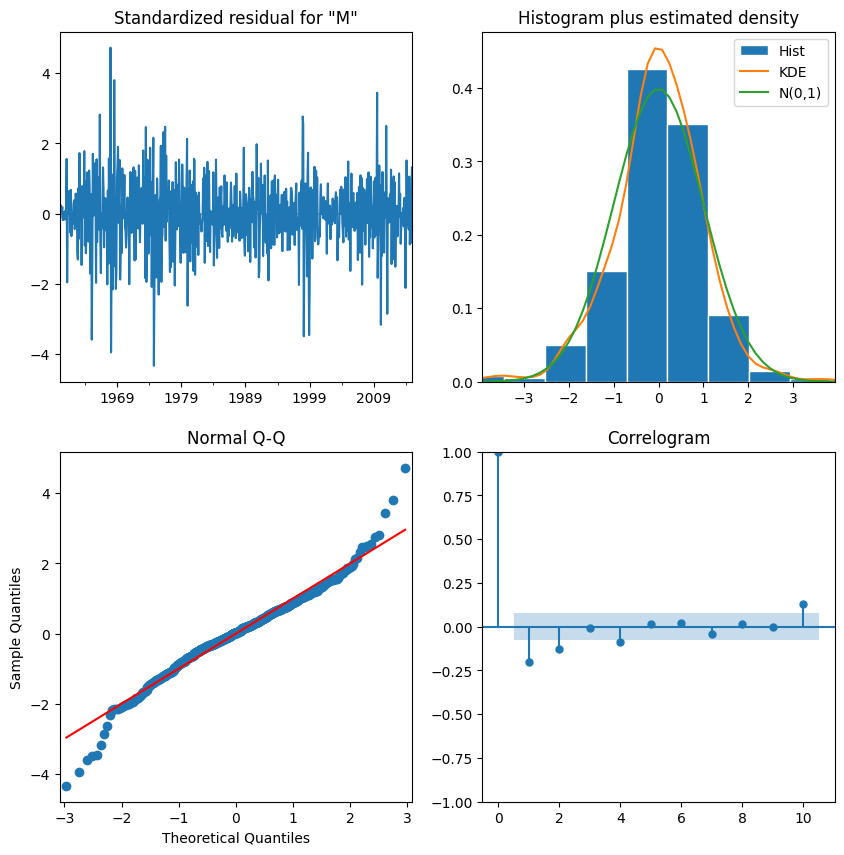

In [63]:
fig =plt.figure(figsize=(10, 10))
ArimaModel.plot_diagnostics(fig=fig);

In [64]:
test["Predicciones"] = ArimaModel.forecast(len(test))

/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_43006/2170066692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = ArimaModel.forecast(len(test))


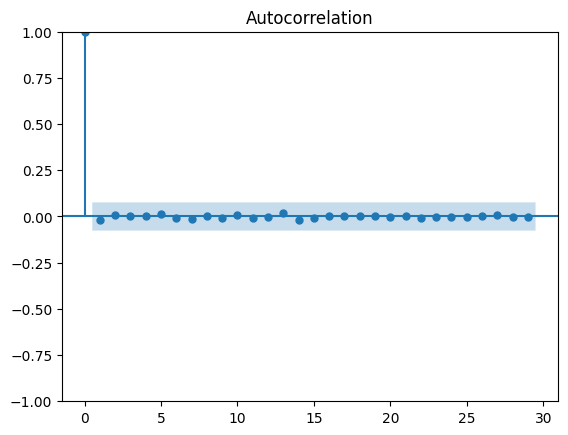

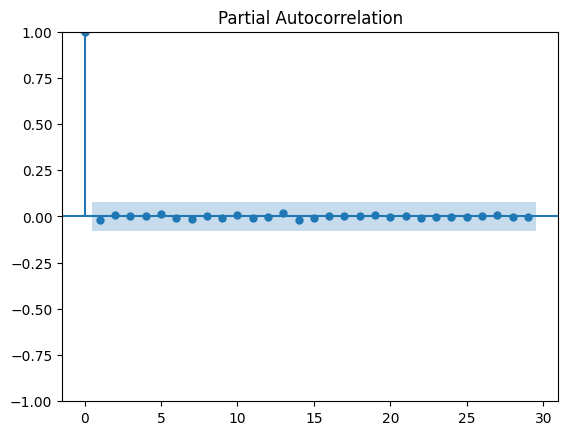

In [66]:


plot_acf(ArimaModel.resid);
plot_pacf(ArimaModel.resid);

### TEst predictions

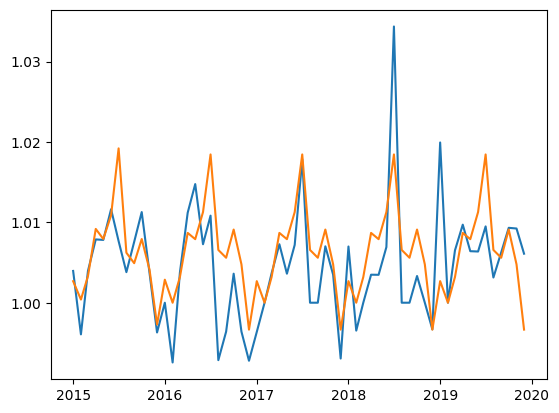

In [67]:


# Esto confirma lo anterior con un mayor numero de Lags


# Analizamos las predicciones mediante el ECM
test.dtypes
ECM = sum((test["Monthly_Inflation"] - test["Predicciones"])**2)/len(test)
ECM

plt.plot(test[["Monthly_Inflation","Predicciones"]])

## Modelo 2 con regresores

In [69]:
train = datos.loc[:"2014-12-01 00:00:00"]
test = datos["2015-01-01 00:00:00":]
print(f"Nº datos de entrenamiento: {train.size}, nº datos de test: {test.size} ")

Nº datos de entrenamiento: 1977, nº datos de test: 180 


/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69170D+00    |proj g|=  2.04461D+01

At iterate    5    f= -2.76913D+00    |proj g|=  1.33634D+02

At iterate   10    f= -3.01758D+00    |proj g|=  1.51776D+00

At iterate   15    f= -3.05208D+00    |proj g|=  1.01348D+01

At iterate   20    f= -3.22046D+00    |proj g|=  1.68556D+00

At iterate   25    f= -3.22318D+00    |proj g|=  1.49648D+00

At iterate   30    f= -3.24407D+00    |proj g|=  7.22160D+00

At iterate   35    f= -3.25072D+00    |proj g|=  1.58249D-01

At iterate   40    f= -3.25164D+00    |proj g|=  6.87359D-01

At iterate   45    f= -3.28934D+00    |proj g|=  1.66851D+01


/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -3.36394D+00    |proj g|=  5.59908D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   5.599D-01  -3.364D+00
  F =  -3.3639370338023729     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                  Monthly_Inflation   No. Observations:                  659
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                2216.835
Date:                            Fri, 03 Feb 2023   AIC                          -4417.6

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


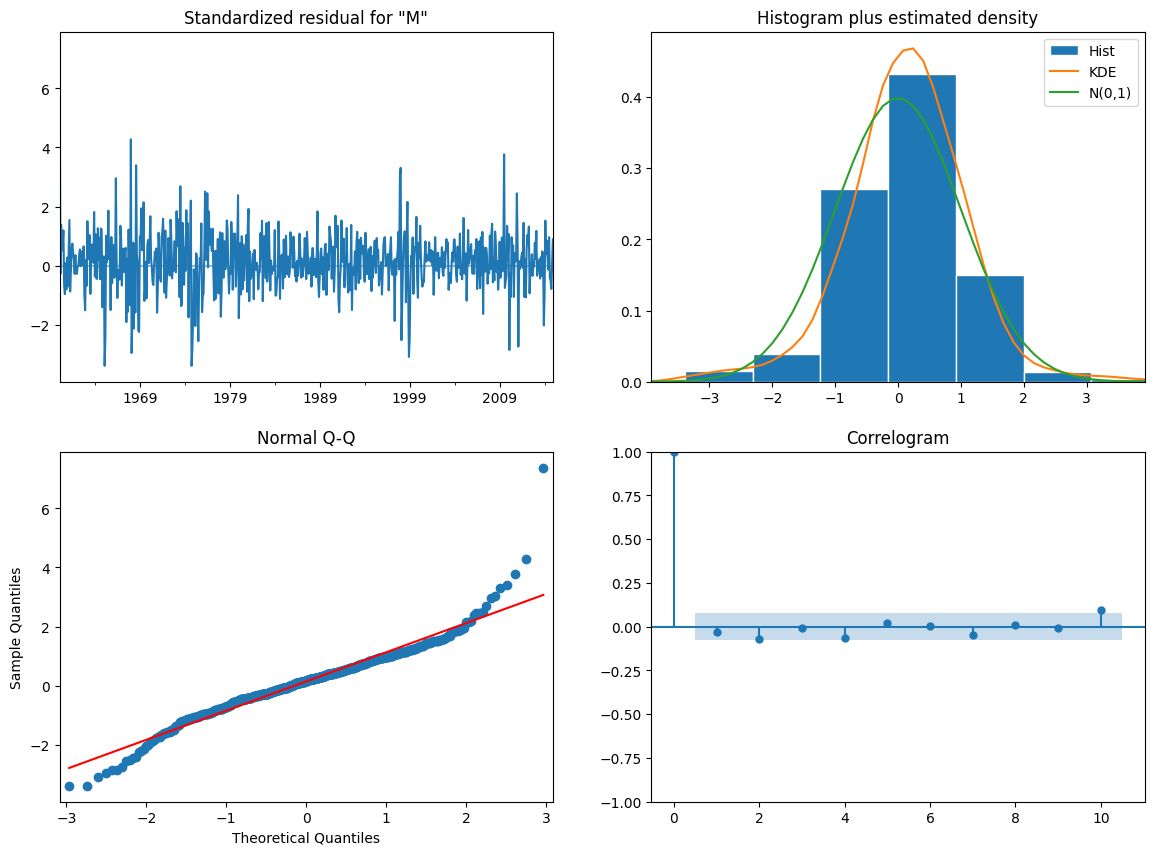

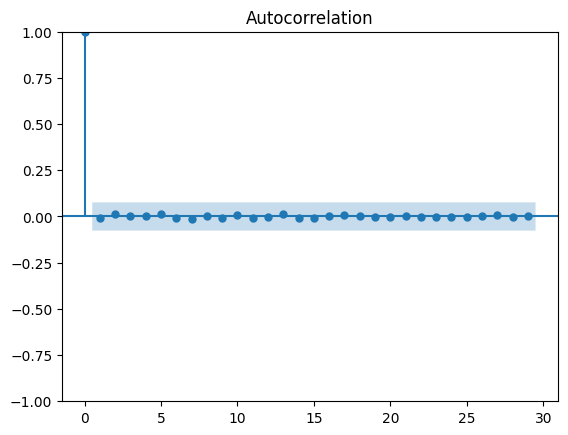

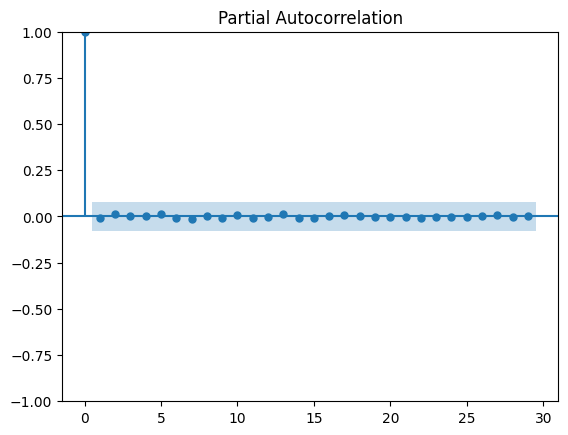

In [70]:
Modelo2 = sm.tsa.statespace.SARIMAX(train["Monthly_Inflation"], order=(1,0,2), seasonal_order=(1,0,2,12),exog = train["Bank Rate"])

ArimaModel2 = Modelo2.fit()
print (ArimaModel2.summary())

# Observamos que el Bank Rate es relevente.

# Comprobamos que el modelo sea correcto
ArimaModel2.plot_diagnostics(figsize = (14,10))

# A primera vista parece peor estimado.

plot_acf(ArimaModel2.resid);
plot_pacf(ArimaModel2.resid);

/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_43006/254995865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = ArimaModel2.forecast(len(test), exog= test["Bank Rate"])


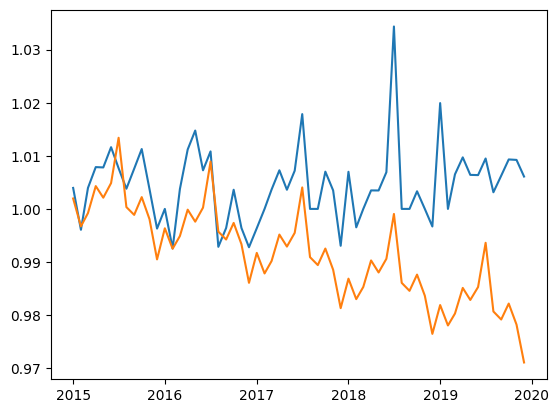

In [71]:
# Realizamos las predicciones
test["Predicciones"] = ArimaModel2.forecast(len(test), exog= test["Bank Rate"])

ECM2 = sum((test["Monthly_Inflation"] - test["Predicciones"])**2)/len(test)
ECM2

plt.plot(test[["Monthly_Inflation","Predicciones"]])

## modelo 3

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.16881D+00    |proj g|=  1.96372D-01

At iterate    5    f= -3.17831D+00    |proj g|=  1.39864D+01

At iterate   10    f= -3.18875D+00    |proj g|=  8.19167D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     53      2     0     0   8.393D-04  -3.189D+00
  F =  -3.1887527881455653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_43006/1327385594.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = ArimaModel.forecast(len(test))


                                     SARIMAX Results                                      
Dep. Variable:                  Monthly_Inflation   No. Observations:                  659
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                2101.388
Date:                            Fri, 03 Feb 2023   AIC                          -4196.776
Time:                                    20:18:20   BIC                          -4183.304
Sample:                                02-01-1960   HQIC                         -4191.554
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   3932.015      0.000       0.999       1.000
ar.S.L12       0.1990      0.035   

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_43006/1327385594.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = ArimaModel2.forecast(len(test), exog= test["Bank Rate"])


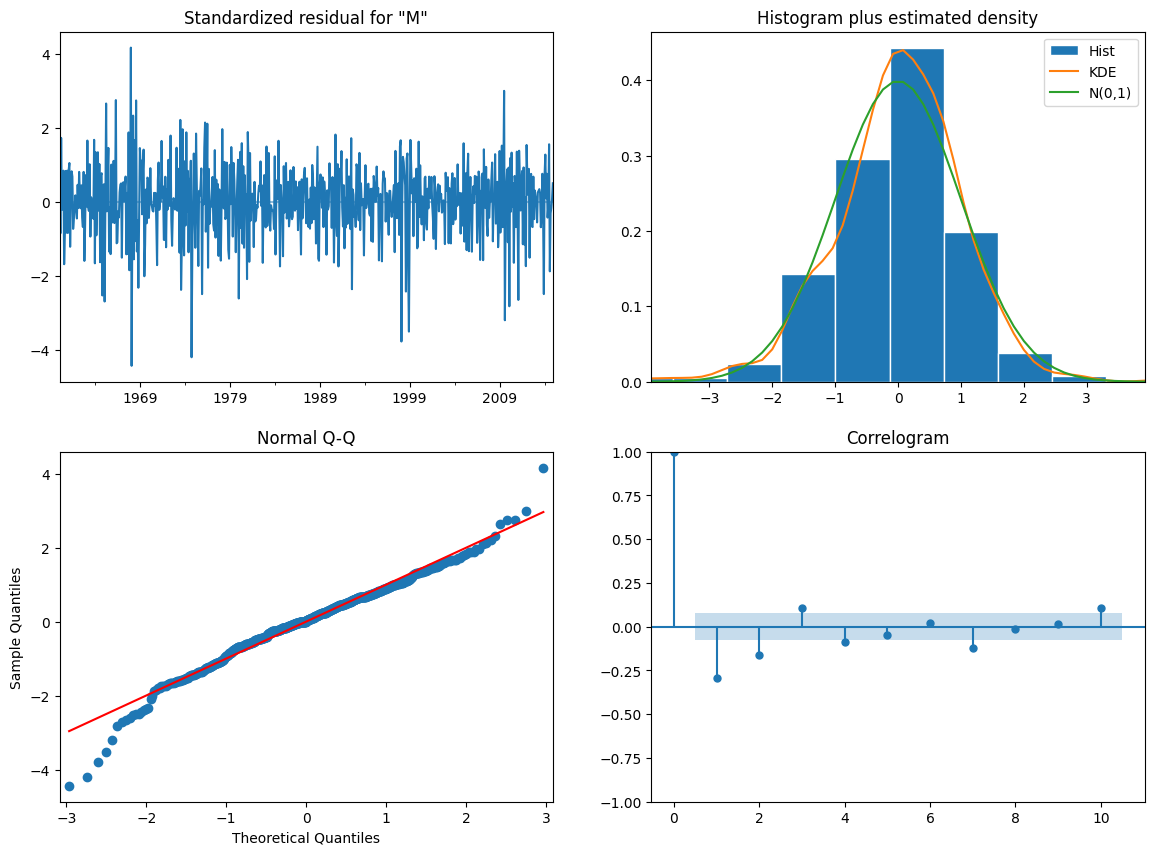

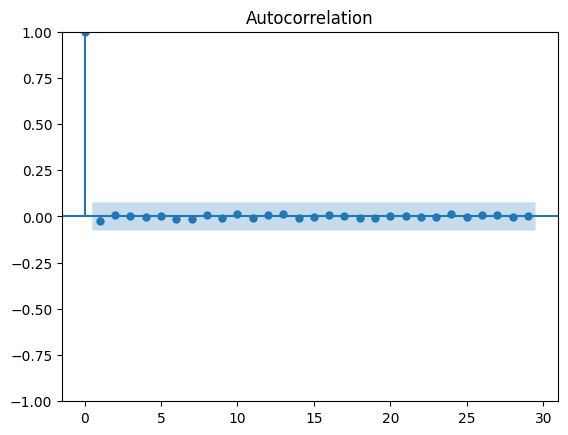

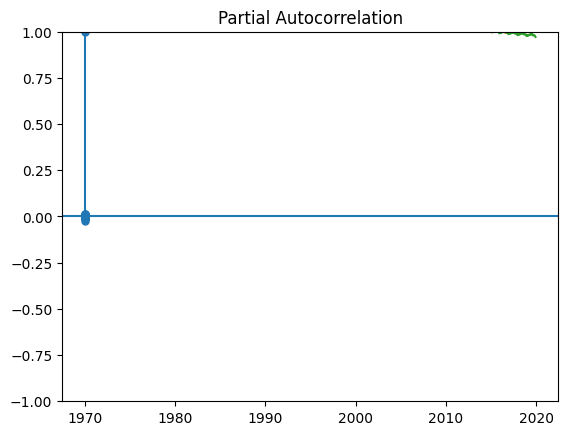

In [72]:

train = datos.loc[:"2014-12-01 00:00:00"]
test = datos["2015-01-01 00:00:00":]

# Entrenaos el modelo segun lo descrito anteriormente.

import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train.iloc[:,1], order=(1,0,0), seasonal_order=(1,0,0,12))

# Visualizamos el modelo
ArimaModel = model.fit()
print (ArimaModel.summary())

# Todos los valores son significativos

# Sacamos las predicciones
test["Predicciones"] = ArimaModel.forecast(len(test))


# Comprobamos que el modelo se ha estimado de forma correcta
# Analizamos los residuos
ArimaModel.plot_diagnostics(figsize = (14,10))

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Parece correcto.

plot_acf(ArimaModel.resid)
plot_pacf(ArimaModel.resid);


# Realizamos las predicciones
test["Predicciones"] = ArimaModel2.forecast(len(test), exog= test["Bank Rate"])

ECM2 = sum((test["Monthly_Inflation"] - test["Predicciones"])**2)/len(test)
ECM2
plt.plot(test[["Monthly_Inflation","Predicciones"]])


## AUTOARIMA

/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/1149551148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/1149551148.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Creditos_Personales"]  = np.exp(test["Creditos_Personales"])
/var/folders/99/x_thvh6101lbzztl8qnh9jyr0000gn/T/ipykernel_41297/1149551148.py:14: SettingWithCopyWarning: 
A value is t

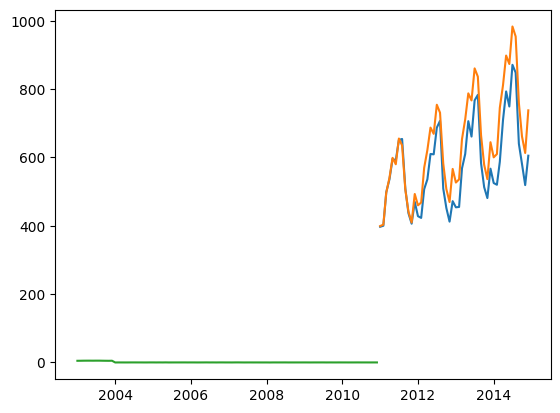

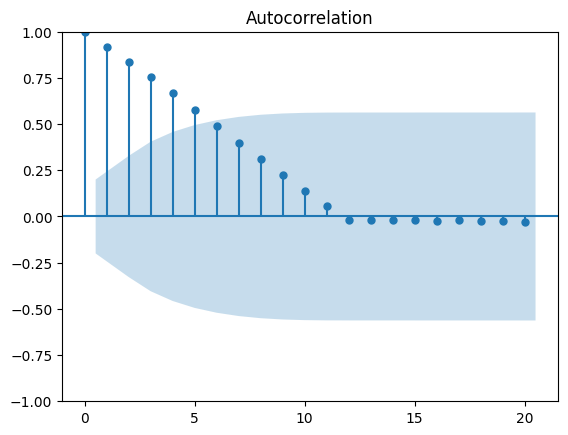

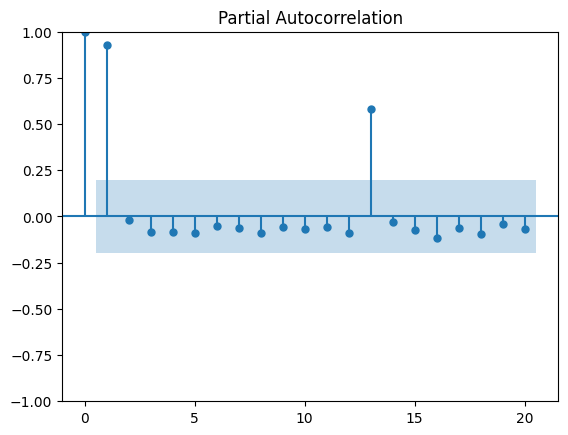

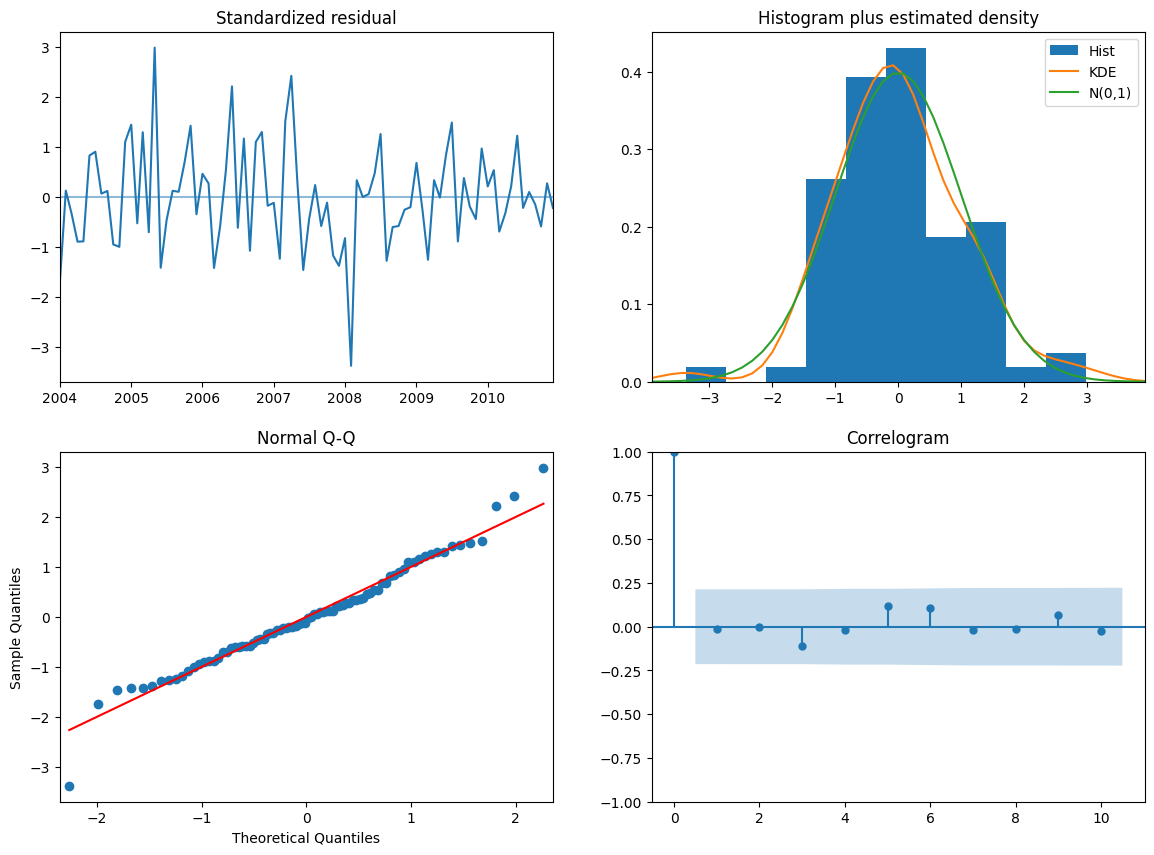

In [141]:

# Pasamos a utilizar el AutoArima  (No lo hace bien)
ArimaModel = pmdarima.auto_arima(train, error_action='ignore', seasonal=True, m=12,start_p=1,start_d=1,start_q=1,max_D=1)

ArimaModel.summary()

# Sacamos las predicciones del modelo.
test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))


# Estas predicciones son logaritmos por lo que hay que invertir el proceso
test["Creditos_Personales"]  = np.exp(test["Creditos_Personales"])
test["Predicciones"]  = np.exp(test["Predicciones"])

# Graficamos los datos de test.
plt.plot(test)


# Analizamos los residuos del modelo.
plt.plot(ArimaModel.resid())

# Comprobamos que los residuos iniciales son altos

# Analizamos el correlograma y el correlograma parcial de los errores
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ArimaModel.resid())
plot_pacf(ArimaModel.resid())

ArimaModel.plot_diagnostics(figsize = (14,10));


In [142]:
ArimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 153.002
Date:                            Fri, 03 Feb 2023   AIC                           -294.003
Time:                                    18:59:59   BIC                           -279.419
Sample:                                01-01-2003   HQIC                          -288.140
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0561      0.029      1.959      0.050   -2.04e-05       0.112
ar.L1          0.5536      0.116      4.778      0.000       0.327       0.781
ar.L2          0.2133      0.112      1.911      0.056      -0.005       0.432
ar.S.L12      -0.5638      0.134     -4.195      0.000      -0.827      -0.300
ar.S.L24      -0.2363      0.158     -1.494      0.135      -0.546       0.074
sigma2         0.0014      0.000      6.173      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.71
Prob(Q):                              0.91   Prob(JB):                         0.10
Heteroskedasticity (H):               0.36   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""